In [180]:
import os
import glob
import copy
import numpy as np
import scipy
import scipy.special
import pandas as pd
import skimage.io
import skimage.morphology
import skimage.filters
import skimage.feature
import seaborn as sns
import statsmodels.tools.numdiff as smnd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

In [97]:
# Directory containing the screenshots
data_dir = '../data/screens/'

# Glob string for TIF image stacks
im_glob = os.path.join(data_dir, '*.png')

# Get list of files in directory
im_list = glob.glob(im_glob)

In [217]:
print(len(ic))

15


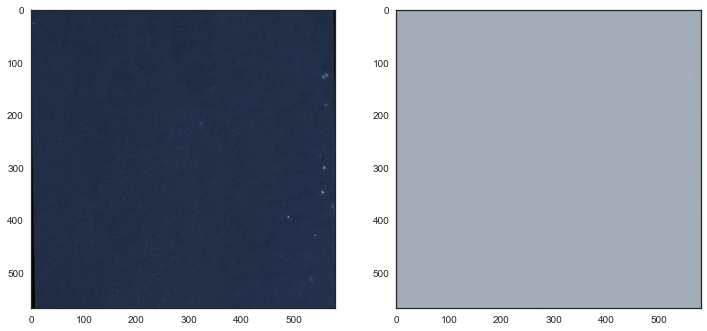

In [245]:
# for fname in im_list:
ic = skimage.io.ImageCollection(im_list, conserve_memory=False)
# skimage.io.imshow(ic[0], cmap=plt.cm.viridis)

# Convert image to float
im_float = skimage.img_as_float(ic[4])

# Filter the image with a strong Gaussian blur
im_bg = skimage.filters.gaussian(im_float, 5.0)

# Show the image and its background
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    ax[0].imshow(im_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_bg, cmap=plt.cm.viridis)

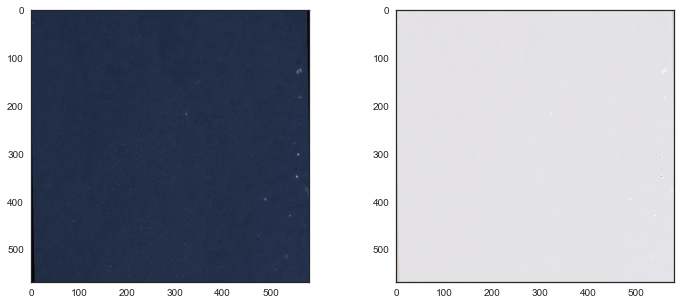

In [246]:
# Subtract background
selem = skimage.morphology.square(3)
im_no_bg = im_float - im_bg

# Show images
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_no_bg, cmap=plt.cm.viridis)

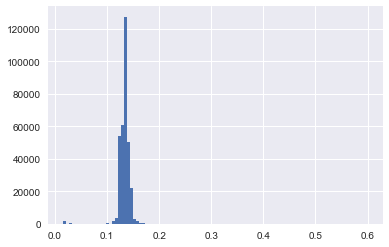

In [247]:
plt.hist(im_float[:,:,0].flatten(), bins=100)
plt.show()

In [248]:
sorted_values = np.sort(im_float[:,:,0].flatten())[::-1]
thesh = sorted_values[int(0.001 * len(sorted_values))]
thesh

0.20392156862745098

329083
(568, 580)


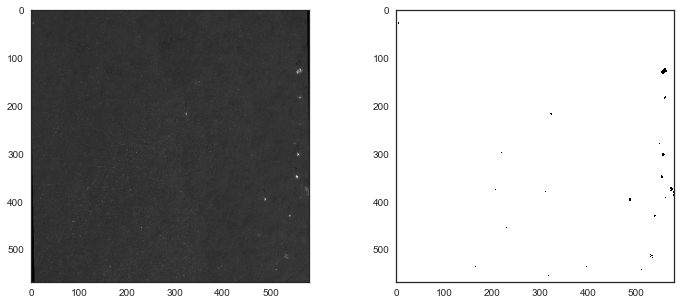

In [249]:
# Threshold image
# thesh =.15
im_bw = im_float[:,:,0] < thesh
print(np.sum(im_bw))
print(im_bw.shape)

# Take a look
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im_float[:,:,0], cmap=plt.cm.gray)
    ax[1].imshow(im_bw, cmap=plt.cm.gray)

In [250]:
print(im_bw.shape)

(568, 580)


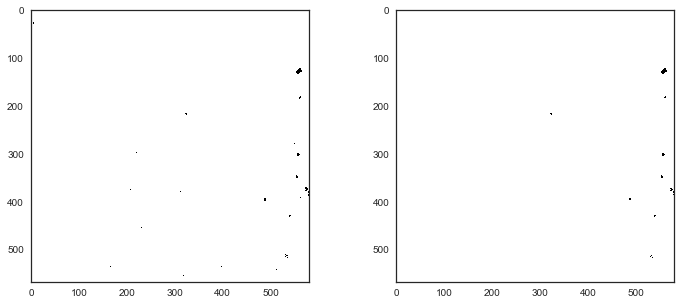

In [251]:
# Use a median filter in a small square structuring element for median filter
# selem = skimage.morphology.square(5)
# im_snp_filt = skimage.filters.rank.median(im_bw, selem)
selem = skimage.morphology.square(3)
im_snp_filt2 = skimage.filters.rank.median(im_bw, selem)

# Show results
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(im_bw, cmap=plt.cm.gray)
    ax[1].imshow(im_snp_filt2, cmap=plt.cm.gray)

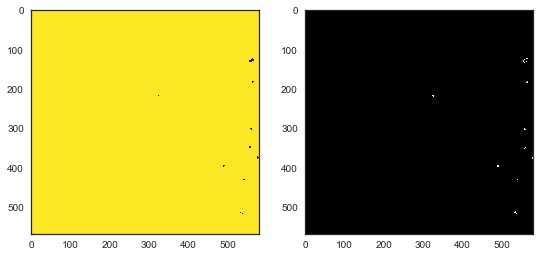

In [252]:
# Do Canny edge detection on image, use sigma = 1.4
im_edge = skimage.feature.canny(im_snp_filt2, 0.3)

# Show the result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_snp_filt2, cmap=plt.cm.viridis)
    ax[1].imshow(im_edge, cmap=plt.cm.gray)

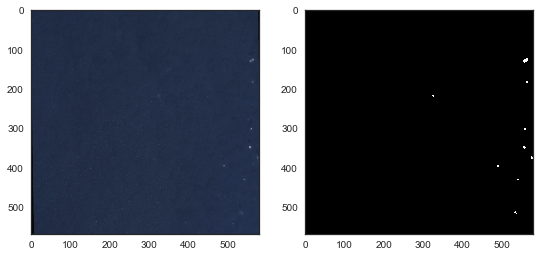

In [253]:
# Fill the holes
im_filled = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Look at result
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_filled, cmap=plt.cm.gray)

Number of ships =  12


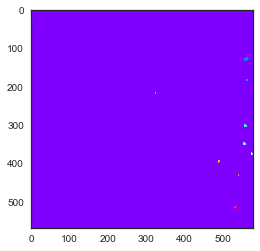

In [254]:
# Label binary image; backward kwarg says value in im_bw to consider backgr.
im_labeled, n_labels = skimage.measure.label(
                            im_filled, background=0, return_num=True)

# See result (one of the few times it's ok to use rainbow colormap!)
with sns.axes_style('white'):
    plt.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of bacteria
print('Number of ships = ', n_labels - 1)

In [255]:
im_props = skimage.measure.regionprops(im_labeled, intensity_image=im_filled)

In [256]:
ships_bboxes = []
for prop in im_props:
    if prop.area > 20:
        ships_bboxes.append([prop.bbox, prop.area])

In [257]:
sorted_bboxes = sorted(ships_bboxes, key=itemgetter(1))
if len(sorted_bboxes) > 10:
    sorted_bboxes = sorted_bboxes[:10]
ships_bboxes = [sb[0] for sb in sorted_bboxes]

In [258]:
def add_bounding_boxes(img, boxes):
    new_img = copy.deepcopy(img)
    for i in range(len(boxes)):
        box = boxes[i]
        print(box)
        for x in range(box[0], box[2] + 1):
            for y in range(box[1], box[3] + 1):
#                 rgb = img.getpixel((x,y))
#                 rgb = (int(conf*rgb[0]), int(conf*rgb[1]), int(conf*rgb[2]), int(255 * (conf)))
                new_img[x][y] = img[x][y] * 0.8
#         img[box[0]:box[2], box[1]] = (1,0,0,1)
#         img[box[0]:box[2], box[3]] = (1,0,0,1)
#         img[box[0], box[1]:box[3]] = (1,0,0,1)
#         img[box[2], box[1]:box[3]] = (1,0,0,1)

#         for x in range(box[0], box[2] + 1):
#             img[x,box[1]] = (1,0,0,1)
#             img[x,box[3]] = (1,0,0,1)
#         for y in range(box[1], box[3] + 1):
#             img[box[0],y] = (1,0,0,1)
#             img[box[2],y] = (1,0,0,1)
    return new_img


(180, 559, 185, 565)
(510, 529, 516, 535)
(392, 486, 398, 492)
(298, 554, 305, 561)
(370, 571, 378, 578)
(344, 551, 352, 559)
(121, 552, 134, 566)


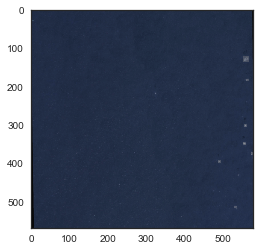

In [259]:
im_boxes = add_bounding_boxes(im_float, ships_bboxes)

with sns.axes_style('white'):
    plt.imshow(im_boxes)